# 06 — MLOps Architecture (Training / Inference / Monitoring)  
# 06 — 生产化架构（训练 / 推理 / 监控）

**核心想法**  
**Core ideas**  
- 数据经 ETL → Task‑A 样本 → 候选召回 → 特征拼装 → 训练（LR/GBDT）→ 注册模型。  
- 批量/在线推理复用候选与特征流水线；指标用 Hits@K/MRR 与 召回率（候选阶段）。  
- 监控：输入分布漂移（船型/区域/距离）、输出命中率、危机期切换回退（Markov）。

```mermaid
flowchart LR
  subgraph Data
    A[Raw CSV: vessels/port_calls/trades] --> B[ETL clean]
  end
  B --> C[Task-A samples]
  C --> D[Temporal Split]
  D --> E[Candidate Recall]
  E --> F[Feature Builder]
  F --> G1[LR Train]
  F --> G2[GBDT Train]
  G1 --> H[Model Registry]
  G2 --> H

  subgraph Inference
    I[Incoming call] --> E2[Recall]
    E2 --> F2[Features]
    F2 --> P[Ranker]
    P --> O[Top-K Next Ports]
  end

  H --> P
```

In [3]:
# ==========================================
# Model to Production
# ==========================================

# covering data pipelines, retraining automation, monitoring, and human feedback loops.

import os
from IPython.display import Markdown, display

display(Markdown("## Model to Production"))


## Model to Production

In [4]:
text = """
The goal is to build a sustainable, monitorable, and iterative ML system
that supports production-grade destination forecasting.
"""
display(Markdown(text))


The goal is to build a sustainable, monitorable, and iterative ML system
that supports production-grade destination forecasting.


In [14]:
text = """
###  Layer 1 — Data & Feature Store

- Data Source: Port calls, trades, vessels, AIS real-time streams
- Feature Store: Synchronize offline/online features (Feast or self-built Feature Registry)
- Goal: Ensure **offline training and online inference use the same feature logic**

---

###  Layer 2 — Model Training & Versioning

- Use MLflow or Kubeflow for automated training, validation, and version registration
- Bind models to feature versions, automatically triggering retraining (weekly or to detect drift)
- Output versions are stored in the Model Registry, along with metadata (date, metrics, features)

---

###  Layer 3 — Serving & Inference

- REST / gRPC API (FastAPI + ONNX/Triton)
- Batch Inference: Run daily to update the destination prediction database
- Online Inference: Return top-K results from real-time requests Next port and confidence level
- Automatic model rollback: Automatically switch to the last stable version if performance degrades

---

###  Layer 4 — Monitoring & Human Feedback

- Monitoring: Data drift, performance drift, system latency
- Alerts: Trigger retraining or manual review
- Feedback loop: Manually correct port predictions and feed them back to the training set
- Visualization: Prometheus + Grafana / MLflow Dashboard
"""

In [15]:
display(Markdown(text))


###  Layer 1 — Data & Feature Store

- Data Source: Port calls, trades, vessels, AIS real-time streams
- Feature Store: Synchronize offline/online features (Feast or self-built Feature Registry)
- Goal: Ensure **offline training and online inference use the same feature logic**

---

###  Layer 2 — Model Training & Versioning

- Use MLflow or Kubeflow for automated training, validation, and version registration
- Bind models to feature versions, automatically triggering retraining (weekly or to detect drift)
- Output versions are stored in the Model Registry, along with metadata (date, metrics, features)

---

###  Layer 3 — Serving & Inference

- REST / gRPC API (FastAPI + ONNX/Triton)
- Batch Inference: Run daily to update the destination prediction database
- Online Inference: Return top-K results from real-time requests Next port and confidence level
- Automatic model rollback: Automatically switch to the last stable version if performance degrades

---

###  Layer 4 — Monitoring & Human Feedback

- Monitoring: Data drift, performance drift, system latency
- Alerts: Trigger retraining or manual review
- Feedback loop: Manually correct port predictions and feed them back to the training set
- Visualization: Prometheus + Grafana / MLflow Dashboard


### MLOps System Flow

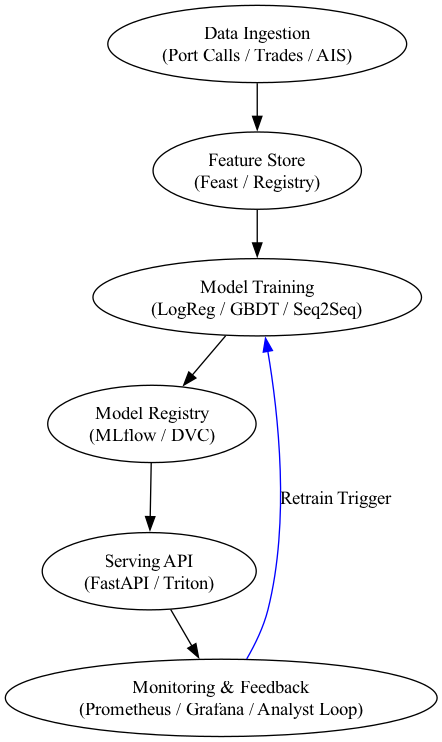

In [7]:
from graphviz import Digraph

dot = Digraph("mlops_pipeline", format="png")
dot.attr(rankdir="TB", size="8,8")

dot.node("A", "Data Ingestion\n(Port Calls / Trades / AIS)")
dot.node("B", "Feature Store\n(Feast / Registry)")
dot.node("C", "Model Training\n(LogReg / GBDT / Seq2Seq)")
dot.node("D", "Model Registry\n(MLflow / DVC)")
dot.node("E", "Serving API\n(FastAPI / Triton)")
dot.node("F", "Monitoring & Feedback\n(Prometheus / Grafana / Analyst Loop)")

dot.edges(["AB", "BC", "CD", "DE", "EF"])
dot.edge("F", "C", label="Retrain Trigger", color="blue")

dot.render("/tmp/mlops_pipeline", cleanup=True)
display(Markdown("### MLOps System Flow"))
from IPython.display import Image
display(Image("/tmp/mlops_pipeline.png"))

In [9]:
display(Markdown("### Automated Retraining Example (Airflow DAG or Python Script)"))

code = """
def retrain_pipeline():

#  Get the latest data
fetch_latest_data("port_calls.csv", "trades.csv")

# Rebuild samples & features
build_samples_taskA()
build_feature_store()

# Train + evaluate + register
model = train_gbdt_ranker()
metrics = evaluate(model)
if metrics['hits@1'] > 0.45:
register_model(model, metrics)
else:
alert_team("Retraining failed")

# Update Serving
deploy_to_triton(model)

# Deployable to Airflow DAG / MLflow Projects
# This function can be run as an Airflow DAG or MLflow pipeline.
"""
display(Markdown(f"```python\n{code}\n```"))

### Automated Retraining Example (Airflow DAG or Python Script)

```python

def retrain_pipeline():

#  Get the latest data
fetch_latest_data("port_calls.csv", "trades.csv")

# Rebuild samples & features
build_samples_taskA()
build_feature_store()

# Train + evaluate + register
model = train_gbdt_ranker()
metrics = evaluate(model)
if metrics['hits@1'] > 0.45:
register_model(model, metrics)
else:
alert_team("Retraining failed")

# Update Serving
deploy_to_triton(model)

# Deployable to Airflow DAG / MLflow Projects
# This function can be run as an Airflow DAG or MLflow pipeline.

```

In [12]:
display(Markdown("""
### 🔍 Drift Detection Logic

- **Data Drift**: KL-Divergence of the current week's port distribution vs. the historical training set > threshold
- **Performance Drift**: Actual port accuracy drops by more than 10%
- **Response Drift**: Average API latency > 500ms
- **Action**:
- Trigger retraining pipeline
- Record version
- Notify engineering team

Example (using Evidently):
```python
from evidently.metric_preset import DataDriftPreset
from evidently.report import Report

report = Report(metrics=[DataDriftPreset()])
report.run(reference_data=train_df, current_data=new_df)
if report.as_dict()['metrics'][0]['result']['dataset_drift']:
trigger_retrain()

SyntaxError: incomplete input (3050449297.py, line 1)

In [ ]:
---

###  Feedback and Continuous Learning / Human-in-the-loop

```python
display(Markdown("""
###  Human-in-the-loop Feedback

- Analyst modifies predicted port → Writes to feedback_log
- System marks high_confidence_corrections=True
- Automatically weights and samples these samples during next retraining
- Improves model performance on rare ports
"""))

In [ ]:
display(Markdown("""
##  Summary
- Data Layer: Consistency + Feature Storage
- Model Layer: Automatic Training + Registration Management
- Service Layer: Online + Batch Inference
- Monitoring Layer: Drift Detection + Feedback Loop

This design supports both the current "next destination prediction" function and can be expanded to future multi-step prediction, anomaly detection, and cargo flow analysis.
"""))